<a href="https://colab.research.google.com/github/felixzhao/Vac-Attack/blob/main/V2_asb_challenge_report_refined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib as mpl

In [2]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [3]:
import tensorflow as tf

In [4]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 27.8 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [5]:
import pmdarima as pm

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# Introduction

## Goals
The goal of this task is to create a forecast of sales expected December 2020 as well as the total expected of the month based on the historical data.

The second goal is to give an insight from the model or data (expecialy around advertisting spend)



## What has been done in this notebook
There are several types of time series forecasting: univariate, multivariat and multiple time series forcasting.

In the following sections a data analsysis has been done. We can see, the "AdvertisingSpend" has a correlation with the "Sales", and "Covid19-lockdown" has negative correlation with the "Sales".



## Forecasting approach
These approaches have been introduced in this work.

ARIMA is a traditional approach which is popular in Time Series Forecasting. In this work, we use it only for univariate forecassting.

Facebook Prophet is a powerful high level API for time series forecasting. In this work, we use it for a multivarite time series forecasting and have done the following tasks.

Handle the "Covid19_lockdown", following Prophet official documentation, which treats the days impacted by Covid19 as holidays that will not repeat again in the future.
Add correlated feature "AdvertisingSpend" into the model
Evaluate model using Cross Validation
Infer the model with "AdvertisingSpend" feature
DNN, in this work we use Tensorflow to create a model from scratch combining CNN and LSTM. This model is used for univariate forecassting.

# Load Data & Pre-processing

This work loads data from google drive. Please put the files into "Vac_Attack" folder under the root of google drive.

Then run the following code to mount the google drive in colab.

You can follow the guide. https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
root_path = "drive/MyDrive/Vac_Attack/"

## Load MarketingSales

In [10]:
marketing_cols = pd.read_csv(f"{root_path}MarketingCols.csv", header=None)
m_cols = [x[0] for x in marketing_cols.to_numpy().tolist()]
raw = pd.read_csv(f"{root_path}MarketingSales.csv", header=None, names=m_cols)
raw.head(2)

,Date,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,Month,Day,0508Line_247,UltraEdition_Available,COVID_Lockdown,Sales
0,1/01/16,0,0,0,4199.86,January,Friday,1,0,0,66
1,2/01/16,0,0,0,14768.20,January,Saturday,1,0,0,84


In [11]:
raw['ds'] = pd.to_datetime(raw.Date)
raw['y'] = raw.Sales
raw_df = raw.drop(['Date', 'Sales'], axis=1)

raw_df.head(2)

,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,Month,Day,0508Line_247,UltraEdition_Available,COVID_Lockdown,ds,y
0,0,0,0,4199.86,January,Friday,1,0,0,2016-01-01,66
1,0,0,0,14768.20,January,Saturday,1,0,0,2016-02-01,84


In [12]:
raw_df.columns

Index(['PositiveNews', 'NegativeCoverage', 'Competition', 'AdvertisingSpend',
       'Month', 'Day', '0508Line_247', 'UltraEdition_Available',
       'COVID_Lockdown', 'ds', 'y'],
      dtype='object')

## Load DecemberAdData

In [13]:
dec_cols = pd.read_csv(f"{root_path}DecemberCols.csv", header=None)
d_cols = [x[0] for x in dec_cols.to_numpy().tolist()]
dec_adv = pd.read_csv(f"{root_path}DecemberAdData.csv", header=None, names=d_cols)
dec_adv.head(2)

,Date,AdvertisingSpend,Month,Day
0,1/12/20,10568.28,December,Tuesday
1,2/12/20,8218.31,December,Wednesday


In [14]:
dec_adv['ds'] = pd.to_datetime(dec_adv.Date)
raw_adv = raw[['ds','AdvertisingSpend', 'Month', 'Day']]
dec_adv_temp = dec_adv[['ds','AdvertisingSpend', 'Month', 'Day']]
forecasting_feaure = pd.concat([raw_adv, dec_adv_temp])
print(f"{len(raw_adv)}, {len(dec_adv)}, {len(forecasting_feaure)}")
forecasting_feaure.tail()

1796, 31, 1827


,ds,AdvertisingSpend,Month,Day
26,2020-12-27,964.54,December,Sunday
27,2020-12-28,578.13,December,Monday
28,2020-12-29,29203.62,December,Tuesday
29,2020-12-30,12686.89,December,Wednesday
30,2020-12-31,9415.00,December,Thursday


## Data Analysis
Explanation of the data used for the analysis

### Correlation Analysis

There are two features correlated with the Sales,
Which are AdvertisingSpend 0.41 and COVID_Lockdown -0.40


In [15]:
raw_df.corr()

,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,0508Line_247,UltraEdition_Available,COVID_Lockdown,y
PositiveNews,1.00,-0.02,-0.01,0.02,0.02,-0.02,0.01,0.12
NegativeCoverage,-0.02,1.00,-0.01,-0.01,-0.01,-0.01,-0.02,-0.07
Competition,-0.01,-0.01,1.00,-0.02,-0.36,0.55,0.32,-0.11
AdvertisingSpend,0.02,-0.01,-0.02,1.00,0.02,-0.01,-0.02,0.41
0508Line_247,0.02,-0.01,-0.36,0.02,1.00,-0.65,-0.11,0.18
UltraEdition_Available,-0.02,-0.01,0.55,-0.01,-0.65,1.00,0.18,-0.12
COVID_Lockdown,0.01,-0.02,0.32,-0.02,-0.11,0.18,1.00,-0.40
y,0.12,-0.07,-0.11,0.41,0.18,-0.12,-0.40,1.00


Next, we use CCF to analysis the Cross-Correlation between Sales and AdvertisingSpend.

CCF stands for Cross-Correlation Function and it is a statistical measure that quantifies the relationship between two time series data sets. It can help determine the extent to which one time series data set can be used to predict another time series data set. The value of CCF ranges from -1 to 1, where -1 represents a negative correlation, 0 represents no correlation, and 1 represents a perfect positive correlation. CCF values can be used in time series forecasting to identify potential relationships between different time series data sets, which can then be used to improve the accuracy of the forecast.



The CCF values of AdvertisingSpend and Sales are positive and have a peak at a certain lag, which means that the two series are positively correlated and that there is a delay in one of the series relative to the other.

In [16]:
lags = range(-len(raw_df)+1, len(raw_df))
ccf = np.correlate(raw_df['AdvertisingSpend'], raw_df['y'], mode='full')

Text(0, 0.5, 'CCF')

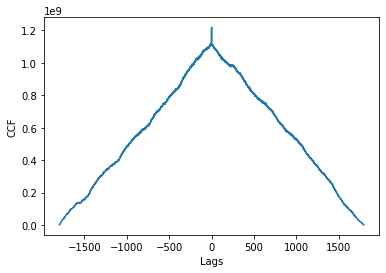

In [17]:
plt.plot(lags, ccf)
plt.xlabel('Lags')
plt.ylabel('CCF')

The following scatter plot also approved above analysis result.

In [18]:
px.scatter(raw_df, x='AdvertisingSpend', y='y', trendline = 'ols', trendline_color_override='red')

### other Data exploration

In [19]:
raw_df.describe()

,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,0508Line_247,UltraEdition_Available,COVID_Lockdown,y
count,1796.00,1796.00,1796.00,1796.00,1796.00,1796.00,1796.00,1796.00
mean,0.03,0.01,0.23,7900.03,0.30,0.49,0.03,78.70
std,0.18,0.09,0.42,6235.05,0.46,0.50,0.17,22.36
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00
25%,0.00,0.00,0.00,2953.03,0.00,0.00,0.00,64.00
50%,0.00,0.00,0.00,6583.47,0.00,0.00,0.00,77.00
75%,0.00,0.00,0.00,11558.74,1.00,1.00,0.00,92.00
max,1.00,1.00,1.00,46586.07,1.00,1.00,1.00,163.00


In [20]:
raw_df.isna().sum()

PositiveNews              0
NegativeCoverage          0
Competition               0
AdvertisingSpend          0
Month                     0
Day                       0
0508Line_247              0
UltraEdition_Available    0
COVID_Lockdown            0
ds                        0
y                         0
dtype: int64

In [21]:
plot_df = raw.copy()
plot_df['year'] = plot_df.ds.dt.year
plot_df['dayofweek'] = plot_df.ds.dt.dayofweek + 1
plot_df = plot_df.groupby(['year', 'dayofweek']).y.mean().reset_index()
px.line(plot_df, x='dayofweek', y='y', color='year', title='Sales')

In [22]:
plot_df = raw.set_index("ds").groupby("PositiveNews").resample("M").y.sum().reset_index()
px.line(plot_df, x = "ds", y= "y", color = "PositiveNews", title = "Monthly total sales with Positive News.")

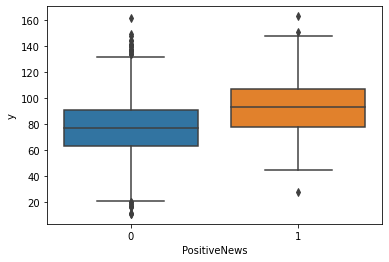

In [ ]:
sns.boxplot(data=raw_df, x='PositiveNews', y='y')

In [23]:
plot_df = raw.set_index("ds").groupby("NegativeCoverage").resample("M").y.sum().reset_index()
px.line(plot_df, x = "ds", y= "y", color = "NegativeCoverage", title = "Monthly total sales of NegativeCoverage.")

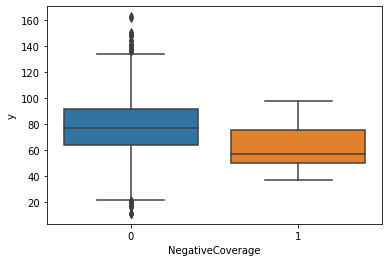

In [24]:
sns.boxplot(data=raw_df, x='NegativeCoverage', y='y')

In [25]:
plot_df = raw.set_index("ds").groupby("Competition").resample("M").y.sum().reset_index()
px.line(plot_df, x = "ds", y= "y", color = "Competition", title = "Monthly total sales of Competition.")

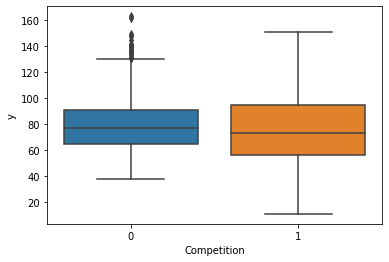

In [ ]:
sns.boxplot(data=raw_df, x='Competition', y='y')

In [26]:
plot_df = raw.set_index("ds").groupby("COVID_Lockdown").resample("M").y.sum().reset_index()
px.line(plot_df, x = "ds", y= "y", color = "COVID_Lockdown", title = "Monthly total sales of COVID Lockdown.")

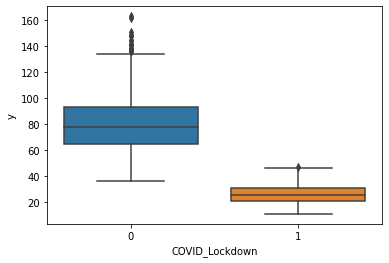

In [27]:
sns.boxplot(data=raw_df, x='COVID_Lockdown', y='y')

In [28]:
plot_df = raw.set_index("ds").groupby("0508Line_247").resample("M").y.sum().reset_index()
px.line(plot_df, x = "ds", y= "y", color = "0508Line_247", title = "Monthly total sales of 0508Line 2*47.")

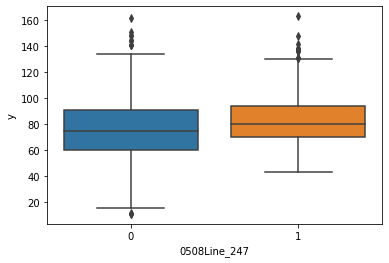

In [29]:
sns.boxplot(data=raw_df, x='0508Line_247', y='y')

In [30]:
plot_df = raw.set_index("ds").groupby("UltraEdition_Available").resample("M").y.sum().reset_index()
px.line(plot_df, x = "ds", y= "y", color = "UltraEdition_Available", title = "Monthly total sales of UltraEdition_Avaliable.")

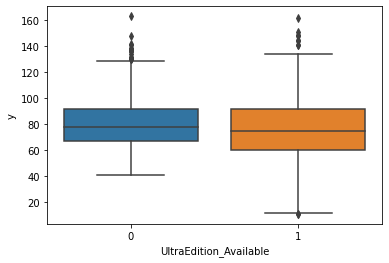

In [31]:
sns.boxplot(data=raw_df, x='UltraEdition_Available', y='y')

As the analysis above, excepted 'COVID_Lockdown', rest of others not strongly related to Sales.

# Model Selection

## ARIMA

ARIMA is an acronym for AutoRegressive Integrated Moving Average. It is a popular statistical method for time series forecasting. ARIMA models the time series as a linear combination of past values, past errors (residuals), and a random white noise term. The "AutoRegressive" (AR) part models the relationship between an observation and a number of lagged observations, the "Integrated" (I) part accounts for non-stationary data through differencing, and the "Moving Average" (MA) part models the relationship between the residual errors and the lagged error terms. The model can be used to make predictions about future values of the time series based on past observations.

ARIMA is suitable for use in a variety of time series forecasting situations, including:

- Univariate time series forecasting, where the model predicts future values based only on past observations of a single variable.
- Stationary time series, where the mean and variance of the time series are constant over time.
- Time series with linear relationships between variables.
- Time series with seasonal patterns.

### ACF and PACF

ACF (Auto-Correlation Function) and PACF (Partial Auto-Correlation Function) are time series analysis tools to measure the correlation between an observation and its past values. ACF measures the correlation between a time series and its lagged values, while PACF measures the correlation between the time series and its lagged values after removing the effect of any correlations due to the intermediate lagged values.

In [32]:
mpl.rc("figure", figsize=(100,10))

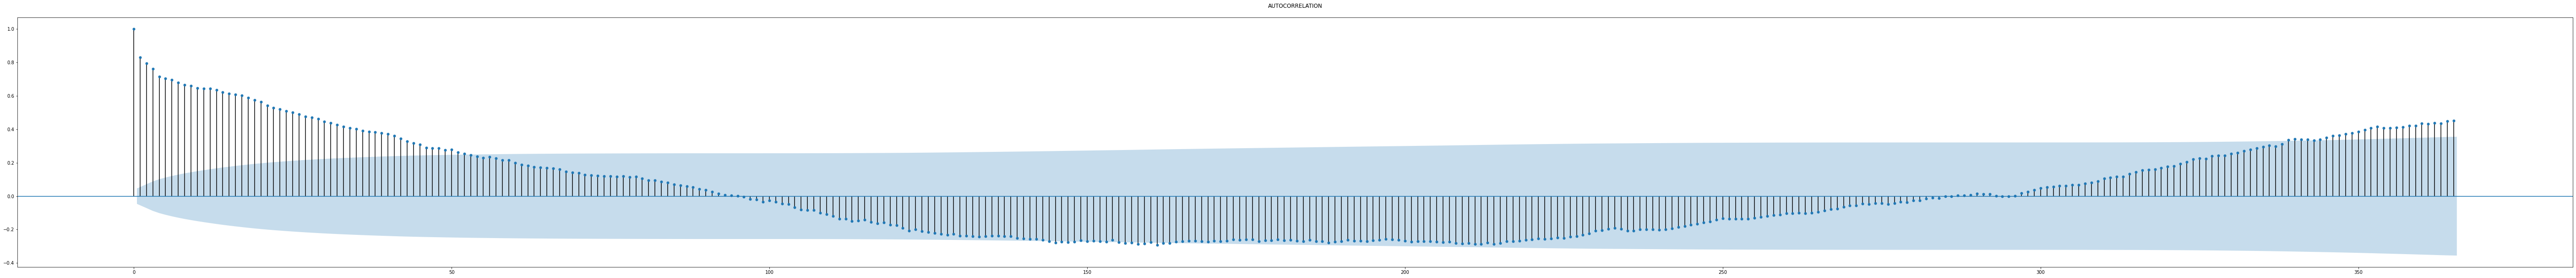

In [34]:
lags = 365
acf = sm.graphics.tsa.plot_acf(raw.Sales, lags=lags,  title = "AUTOCORRELATION\n")

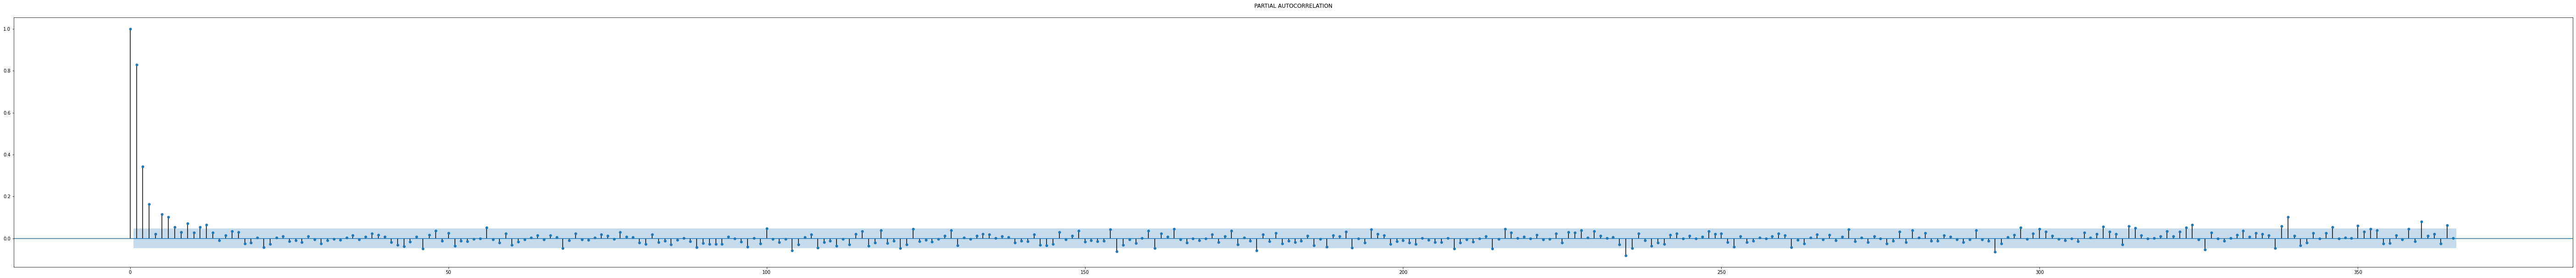

In [35]:
pacf = sm.graphics.tsa.plot_pacf(raw.Sales, lags=lags, title = "PARTIAL AUTOCORRELATION\n")

We can use ACF and PACF to create ARIMA model but as ploted above it hard to detemeter.

### Auto ARIMA

In this work we can use pmdarima to automatically create an ARIMA model.

pmdarima (Python Machine Learning for ARIMA) is a library in Python for automatically selecting and tuning the parameters of an ARIMA time series model. It uses a combination of statistical techniques and machine learning algorithms to perform a search over a large space of possible ARIMA models, and selects the best model based on its performance on the training data.

In [36]:
arima_raw = raw_df.copy()
arima_df = arima_raw[['ds','y']]
arima_df.tail(2)

,ds,y
1794,2020-11-29,98
1795,2020-11-30,94


In [37]:
arima_df = arima_df.set_index('ds')
arima_df.tail(2)

,y
ds,
2020-11-29,98
2020-11-30,94


In [ ]:
m = pm.auto_arima(arima_df['y'], m=12, seasonal=True, start_p=0, start_q=0, max_order=4, test='adf', 
                  error_action='ignore', suppress_warnings=True, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=10.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=16261.390, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=14163.888, Time=6.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=14968.755, Time=4.86 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=20919.673, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=14178.330, Time=0.30 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=14158.870, Time=10.84 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=14156.365, Time=20.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=14154.335, Time=6.53 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=14165.974, Time=2.31 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=14156.322, Time=21.93 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=14161.209, Time=7.99 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=14156.686, Time=28.64 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=13949.572, Time=4.95 sec
 ARIMA

In [ ]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1796
Model:             SARIMAX(3, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -6924.910
Date:                            Mon, 23 Jan 2023   AIC                          13863.820
Time:                                    06:54:24   BIC                          13902.274
Sample:                                         0   HQIC                         13878.016
                                           - 1796                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8112      0.294      2.755      0.006       0.234       1.388
ar.L1          1.2896      0.042     30.678      0.000       1.207       1.372
ar.L2         -0.1628      0.037     -4.374      0.000      -0.236      -0.090
ar.L3         -0.1371      0.033     -4.212      0.000      -0.201      -0.073
ma.L1         -0.8338      0.035    -23.589      0.000      -0.903      -0.765
ma.S.L12       0.0416      0.025      1.661      0.097      -0.007       0.091
sigma2       130.4184      3.267     39.923      0.000     124.016     136.821
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               307.08
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.40
Prob(H) (two-sided):                  0.79   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
m.fit(arima_df['y'])
forecast = m.predict(n_periods=31, return_conf_int=True)
forecast

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



(1796   96.20
 1797   95.95
 1798   96.09
 1799   95.94
 1800   96.45
 1801   95.54
 1802   95.29
 1803   94.73
 1804   94.71
 1805   95.11
 1806   94.14
 1807   93.67
 1808   93.51
 1809   93.25
 1810   93.00
 1811   92.74
 1812   92.49
 1813   92.23
 1814   91.98
 1815   91.74
 1816   91.50
 1817   91.26
 1818   91.02
 1819   90.80
 1820   90.57
 1821   90.35
 1822   90.13
 1823   89.92
 1824   89.71
 1825   89.51
 1826   89.31
 dtype: float64, array([[ 73.8123155 , 118.57823059],
        [ 71.3538646 , 120.55086554],
        [ 69.71850953, 122.46650637],
        [ 68.50510656, 123.36554925],
        [ 68.20059974, 124.70922682],
        [ 66.61557882, 124.47059802],
        [ 65.77294465, 124.805036  ],
        [ 64.68228794, 124.77659539],
        [ 64.1741517 , 125.24823132],
        [ 64.1191465 , 126.10826906],
        [ 62.71212361, 125.56244568],
        [ 61.84096973, 125.5056321 ],
        [ 61.13863616, 125.88914076],
        [ 60.44404716, 126.05676006],
        [ 59.78752

In [ ]:
forecast_range=pd.date_range(start='2020-12-01', periods=31, freq='D')
forecast_range

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
forecast_df = pd.DataFrame(data=forecast[0].tolist(), index=forecast_range, columns=['pred'])
forecast_df

,pred
2020-12-01,96.20
2020-12-02,95.95
2020-12-03,96.09
2020-12-04,95.94
2020-12-05,96.45
2020-12-06,95.54
2020-12-07,95.29
2020-12-08,94.73
2020-12-09,94.71
2020-12-10,95.11


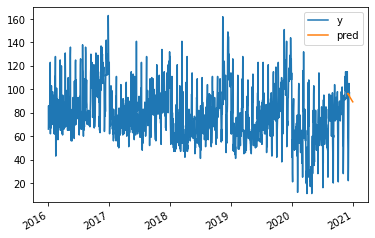

In [ ]:
pd.concat([arima_df['y'], forecast_df], axis=1).plot()

Based on diagnostics QQ plot, we can see the residual of the model is following Normal Distribution.

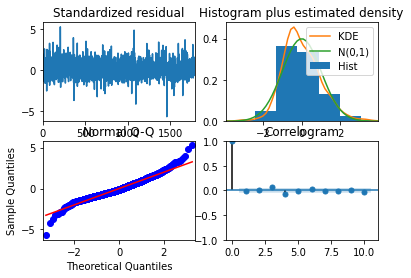

In [ ]:
out = m.plot_diagnostics()

### DEC sales prediction by ARIMA

In [ ]:
print(f"total expected of Sales by ARIMA in Dec: {forecast_df.pred.sum()}")
forecast_df

total expected of Sales by ARIMA in Dec: 2878.8513926731985


,pred
2020-12-01,96.20
2020-12-02,95.95
2020-12-03,96.09
2020-12-04,95.94
2020-12-05,96.45
2020-12-06,95.54
2020-12-07,95.29
2020-12-08,94.73
2020-12-09,94.71
2020-12-10,95.11


## Prophet

Prophet is a time series forecasting library developed by Facebook, designed for analyzing and modeling time series data. It is based on a decomposable model that consists of three main components: trend, seasonality, and holiday effects. It provides a simple interface for creating and fitting time series models, and is particularly well suited for business forecasting tasks, handling seasonality and holidays in the data. Prophet is implemented in Python and is available for use as an open source library.

Prophet is best used for:

- Time series forecasting with a strong yearly or weekly seasonality and potential for multiple trends.
- Business forecasting, such as predicting sales or demand.
- Forecasting events with clear patterns, such as holidays or special events.
- Time series with well defined seasonality patterns, but with irregular fluctuations.
- Time series with relatively long historical data to train the model.

### handle COV-19 period

To prevent large dips and spikes from being captured by the trend component, we can treat the days impacted by COVID-19 as holidays that will not repeat again in the future. We set up a DataFrame like so to describe the periods affected by lockdowns:

from: https://facebook.github.io/prophet/docs/handling_shocks.html#treating-covid-19-lockdowns-as-a-one-off-holidays

In [40]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-25', 'lower_window': 0, 'ds_upper': '2020-05-15'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-25,0,2020-05-15,51


In [41]:
m = Prophet(holidays=lockdowns, interval_width=0.95, yearly_seasonality=True)
m.add_regressor('AdvertisingSpend')
m.fit(raw_df)
prophet_forecast = m.predict(forecasting_feaure)
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc80edkvg/0dvonzvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc80edkvg/ve9c2kna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55864', 'data', 'file=/tmp/tmpc80edkvg/0dvonzvb.json', 'init=/tmp/tmpc80edkvg/ve9c2kna.json', 'output', 'file=/tmp/tmpc80edkvg/prophet_modelo_a1qqfg/prophet_model-20230130183103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1822,2020-12-27,89.57,58.76,118.38
1823,2020-12-28,88.10,58.30,118.76
1824,2020-12-29,125.82,98.06,156.34
1825,2020-12-30,100.74,73.79,131.45
1826,2020-12-31,94.35,63.06,123.14


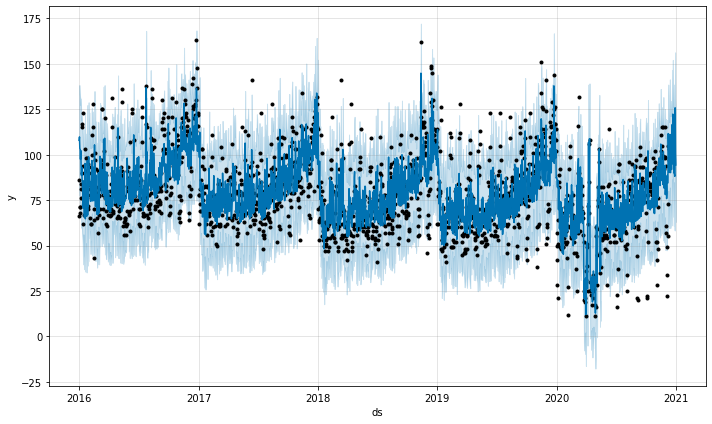

In [42]:
fig1 = m.plot(prophet_forecast)

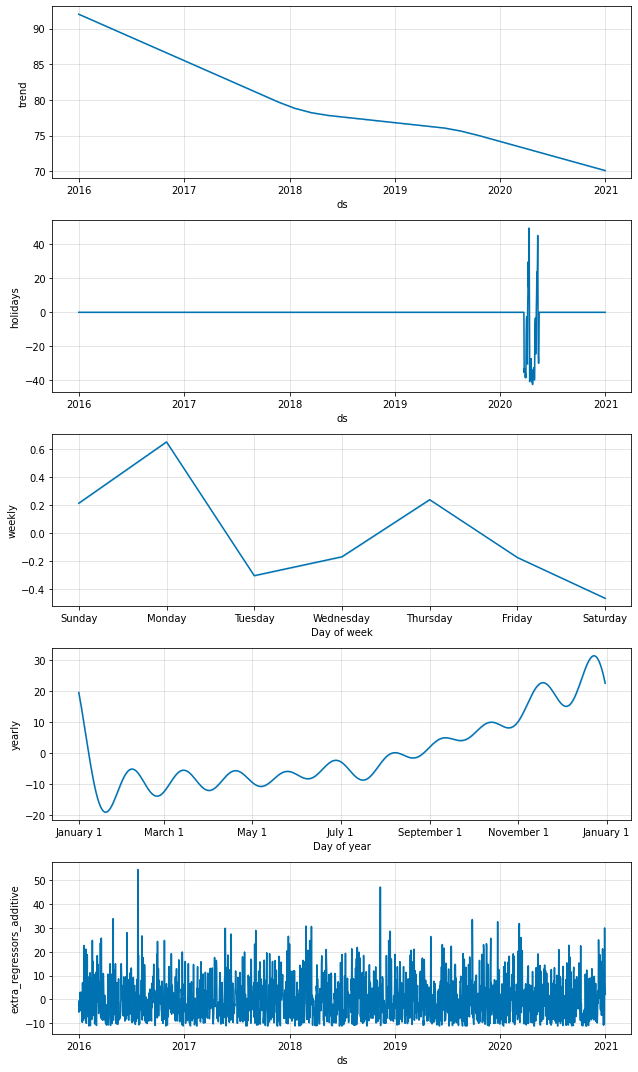

In [43]:
fig2 = m.plot_components(prophet_forecast)

In [44]:
plot_plotly(m, prophet_forecast)

In [45]:
plot_components_plotly(m, prophet_forecast)

### Prophet Cross Validation

In [46]:
cv_result = cross_validation(model=m, horizon="300 days")
cv_result

INFO:prophet:Making 5 forecasts with cutoffs between 2018-06-25 00:00:00 and 2020-02-15 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpc80edkvg/1wcwxdfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc80edkvg/tb75xhpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14030', 'data', 'file=/tmp/tmpc80edkvg/1wcwxdfg.json', 'init=/tmp/tmpc80edkvg/tb75xhpb.json', 'output', 'file=/tmp/tmpc80edkvg/prophet_modelue9j1fz0/prophet_model-20230130183115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc80edkvg/5sueco46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc80edkvg/qz4vggyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-06-26,67.48,41.10,92.42,58,2018-06-25
1,2018-06-27,88.76,61.04,114.75,71,2018-06-25
2,2018-06-28,61.78,35.34,90.26,60,2018-06-25
3,2018-06-29,82.16,54.44,108.17,71,2018-06-25
4,2018-06-30,70.51,41.92,97.81,69,2018-06-25
...,...,...,...,...,...,...
1477,2020-12-07,93.43,64.78,123.43,73,2020-02-15
1478,2020-12-08,118.17,91.78,147.87,105,2020-02-15
1479,2020-12-09,109.97,81.41,138.29,103,2020-02-15
1480,2020-12-10,100.10,72.17,127.20,94,2020-02-15


Based on the Prophet Cross Validation result the RMSE of 31 days is 17.58

In [47]:
df_p = performance_metrics(cv_result)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,312.59,17.68,13.62,0.19,0.13,0.18,0.86
1,31 days,309.02,17.58,13.40,0.19,0.12,0.17,0.86
2,32 days,305.79,17.49,13.25,0.18,0.12,0.17,0.86
3,33 days,304.00,17.44,13.16,0.18,0.12,0.17,0.86
4,34 days,302.25,17.39,13.02,0.18,0.12,0.17,0.86
...,...,...,...,...,...,...,...,...
266,296 days,321.68,17.94,12.56,0.25,0.12,0.19,0.87
267,297 days,326.67,18.07,12.70,0.25,0.12,0.19,0.87
268,298 days,324.08,18.00,12.61,0.25,0.12,0.19,0.87
269,299 days,323.98,18.00,12.65,0.25,0.12,0.19,0.87


In [48]:
prophet_dec = prophet_forecast[['ds', 'yhat']].tail(31)

### DEC sales prediction by Prophet

In [49]:
print(f"total expected of Sales by ARIMA in Dec:{prophet_dec.yhat.sum()}")
prophet_dec

total expected of Sales by ARIMA in Dec:3009.315445289681


,ds,yhat
1796,2020-12-01,87.57
1797,2020-12-02,82.73
1798,2020-12-03,75.83
1799,2020-12-04,78.66
1800,2020-12-05,88.65
1801,2020-12-06,84.30
1802,2020-12-07,87.80
1803,2020-12-08,111.63
1804,2020-12-09,103.29
1805,2020-12-10,93.72


## DNN (CNN + LSTM)

Here we use an CNN + LSTM solution.

Convolutional neural networks (CNNs) are commonly used in image and video processing tasks, but they can also be applied to time series data. In particular, a 1D convolutional layer (Conv1D) can be used to extract features from a time series by sliding a kernel (a small matrix of weights) along the sequence, performing a dot product at each position, and applying a non-linear activation function. This allows the model to learn local patterns in the data, such as trends or periodicity, that may be useful for classification. Additionally, Conv1D can also be used in combination with pooling layers to reduce the dimensionality of the data and make the model more robust to noise.

### Utilities

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    # plt.show()

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

### data preparation

In [ ]:
time = raw_df.ds.to_numpy()
series = raw_df.y.to_numpy()

In [ ]:
# Define the split time
split_time = len(series) - 31

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
# Parameters
window_size = 31
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

### Build the Model

In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 31, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 31, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

### Tune the Learning Rate

In [ ]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])

Epoch 1/20
55/55 [==============================] - 6s 41ms/step - loss: 301.6187 - lr: 1.0000e-08
Epoch 2/20
55/55 [==============================] - 2s 42ms/step - loss: 213.8299 - lr: 1.1220e-08
Epoch 3/20
55/55 [==============================] - 2s 41ms/step - loss: 164.3795 - lr: 1.2589e-08
Epoch 4/20
55/55 [==============================] - 2s 41ms/step - loss: 124.1072 - lr: 1.4125e-08
Epoch 5/20
55/55 [==============================] - 2s 40ms/step - loss: 81.7841 - lr: 1.5849e-08
Epoch 6/20
55/55 [==============================] - 2s 40ms/step - loss: 42.6262 - lr: 1.7783e-08
Epoch 7/20
55/55 [==============================] - 2s 41ms/step - loss: 17.2656 - lr: 1.9953e-08
Epoch 8/20
55/55 [==============================] - 2s 40ms/step - loss: 13.4517 - lr: 2.2387e-08
Epoch 9/20
55/55 [==============================] - 2s 41ms/step - loss: 13.2498 - lr: 2.5119e-08
Epoch 10/20
55/55 [==============================] - 2s 41ms/step - loss: 13.0747 - lr: 2.8184e-08
Epoch 11/20
55/

(1e-08, 0.001, 0.0, 20.0)

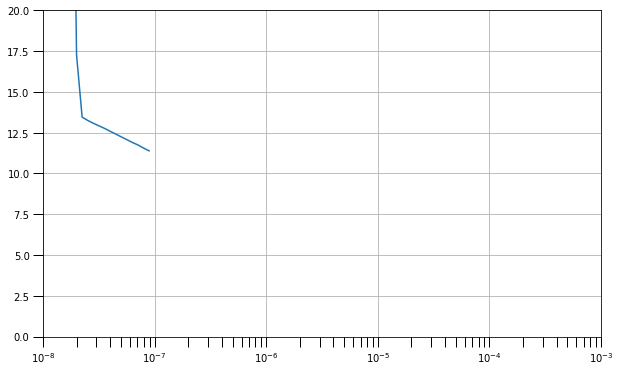

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(20) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 20])

### Train the Model

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 10e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(train_set,epochs=20)

Epoch 1/20
55/55 [==============================] - 6s 41ms/step - loss: 50.7199 - mae: 51.2138
Epoch 2/20
55/55 [==============================] - 2s 40ms/step - loss: 11.8047 - mae: 12.2962
Epoch 3/20
55/55 [==============================] - 2s 40ms/step - loss: 10.3724 - mae: 10.8615
Epoch 4/20
55/55 [==============================] - 2s 40ms/step - loss: 9.7530 - mae: 10.2431
Epoch 5/20
55/55 [==============================] - 2s 41ms/step - loss: 9.3792 - mae: 9.8648
Epoch 6/20
55/55 [==============================] - 2s 40ms/step - loss: 9.4609 - mae: 9.9514
Epoch 7/20
55/55 [==============================] - 2s 41ms/step - loss: 9.4361 - mae: 9.9251
Epoch 8/20
55/55 [==============================] - 2s 40ms/step - loss: 9.2716 - mae: 9.7605
Epoch 9/20
55/55 [==============================] - 2s 40ms/step - loss: 9.2298 - mae: 9.7177
Epoch 10/20
55/55 [==============================] - 2s 40ms/step - loss: 9.1526 - mae: 9.6415
Epoch 11/20
55/55 [==============================] -

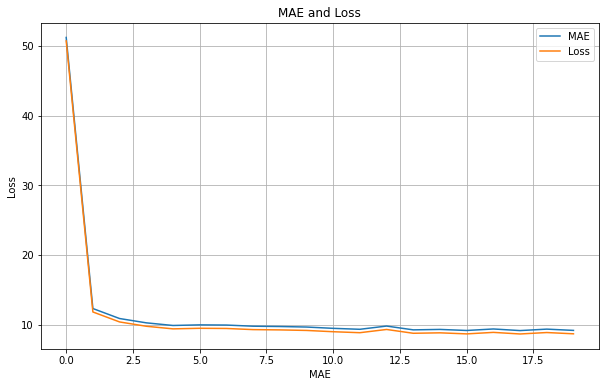

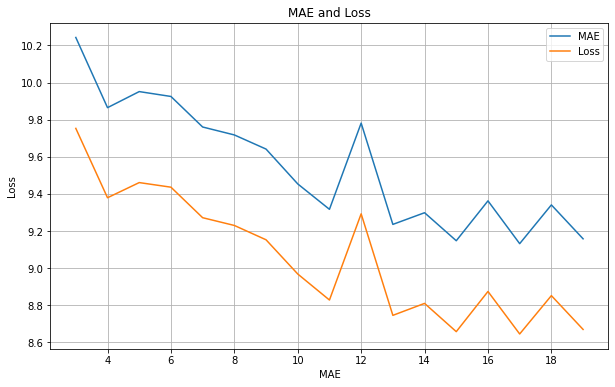

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

### validation

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

1/1 [==============================] - 1s 1s/step


In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

6.865936


In [ ]:
print(len(results))
results[:31]

31


array([ 93.14128 ,  92.9933  ,  93.32771 ,  96.4871  , 101.54041 ,
       100.34151 ,  96.18838 ,  97.58449 ,  96.085785,  93.63751 ,
        93.68463 ,  92.919304,  93.38849 ,  95.58237 ,  96.428696,
        96.0285  ,  99.94907 , 101.197266, 100.26987 , 103.28939 ,
       103.8534  , 102.519844, 101.97881 , 101.66141 , 105.176796,
       104.824   , 102.54118 , 101.39147 , 101.56486 , 105.32716 ,
       105.0134  ], dtype=float32)

In [ ]:
len(x_valid)

31

In [ ]:
forecast_range=pd.date_range(start='2020-12-01', periods=31, freq='D')
forecast_range

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
forecast_df = pd.DataFrame(results, index=forecast_range, columns=['yhat'])

### DEC sales prediction by DNN

In [ ]:
print(f"total expected of Sales by DNN in Dec:{forecast_df.yhat.sum()}")
forecast_df

total expected of Sales by DNN in Dec:3069.91748046875


,yhat
2020-12-01,93.14
2020-12-02,92.99
2020-12-03,93.33
2020-12-04,96.49
2020-12-05,101.54
2020-12-06,100.34
2020-12-07,96.19
2020-12-08,97.58
2020-12-09,96.09
2020-12-10,93.64


# Model Comparison

## ARIMA

Pros:

- ARIMA is a widely used model for time series forecasting and is simple to understand.
- It can handle non-stationary data through differencing and can model linear relationships between variables.

Cons:

- It assumes a linear relationship between the variables, which may not always be the case.
- It can be difficult to determine the best values for the parameters of the model.
- It does not handle exogenous variables well.
- It assumes that the error terms are normally distributed and homoscedastic, which may not always be the case in real-world data.

## Prophet

Pros:

- Easy to use and interpret, with a simple interface for creating models.
- Handles missing data and outliers well.
- Can model multiple seasonalities, trends and growth patterns in the data.
- Provides uncertainty intervals for predictions.

Cons:

- Limited ability to handle complex relationships between variables.
- May not perform well on long term forecasts.
- Limited ability to handle large datasets efficiently.
- May struggle with irregular time series or data with non-stationary patterns.

## DNN (CNN + LSTM)

The combination of Convolutional Neural Networks (CNN) and Long Short-Term Memory (LSTM) works for multi-variable time series forecasting because:

- CNNs are good at extracting features from sequences, such as spatial patterns in the data.

- LSTMs are designed to capture long-term dependencies in sequences and preserve memory from earlier time steps.

- By combining these two, the CNN can identify relevant features, and the LSTM can use these features to make predictions for future time steps.

The two architectures complement each other and allow the network to learn both local and global patterns in the data, which is useful for multi-variable time series forecasting.

Pros:

- Good at capturing both short-term and long-term dependencies in multi-variable time series data.

- Can handle input data with different scales and distributions.

- Good at feature extraction, which can improve the overall accuracy of the model.

- Works well with large amounts of data.

Cons:

- Can be computationally expensive, especially when the input sequence is very long.

- Can be difficult to interpret and understand the internal workings of the model.

- May have difficulty handling data with missing values or noisy data.

- Requires a large amount of training data, which may not always be available.

- Hyperparameter tuning can be challenging and time-consuming, as there are many parameters to optimize.

# Results



## Forecasted sales for December 2020


## Total expected sales for the month


## Insights from the data
Visualization of the results (optional)

# Conclusion

## Summary of the findings


Total Sales prediction of December: __3009.32__ 





The Total Sales in december prediction from ARIMA is 2878.85, from Prophet is 3009.32 and from DNN is 3069.92, which are close in value. We choice the Prophet as our prediction as other two need future tunning.

ARIMA is a traditional method and DNN can be used to  create model from scrach which gives more flexibility.
Both ARIMA and DNN take long time to run,  so in this work we only use them for univariate forecasting to reduce complexity.

If we have more time, we can refine the DNN model.

Prophet is the easiest way to use and it takes shorter time to run than other two approaches. That's why in this work it has been adopted for the multivarite forecasting work and handling the Covid19-lockdown.

At last, the "PositiveNews", "NegativeCoverage","Competition", "0508Line_247" and "UltraEdition_Available" are not included in the model.

The first reason is the results based on the EDA, which are less correlated with the "Sales". Another reason is that "PositiveNews" and "NegativeCoverage" are clearly unknown in the prediction. So, it requires us to predict "Sales" based on the prediction results of "PositiveNews" and "NegativeCoverage". This will increase the uncertainty.




## Implications for the company


The sales of the company have returned to pre-COVID levels based on the monthly sales plot. 

However, despite this short-term recovery, the yearly sales plot reveals a downward trend, indicating that the impact of the pandemic has yet to fully dissipate.

In [50]:
sales_with_prediction = forecasting_feaure[['ds','AdvertisingSpend']].set_index('ds').join(prophet_forecast[['ds', 'yhat']].set_index('ds'))
print(sales_with_prediction.shape)
# sales_with_prediction.tail(2)

(1827, 2)


In [51]:
plot_df = sales_with_prediction.resample("M").yhat.sum().reset_index()
px.line(plot_df, x = "ds", y= "yhat", title = "Monthly total sales with prediction.")

In [52]:
plot_df = sales_with_prediction.resample("Y").yhat.sum().reset_index()
px.line(plot_df, x = "ds", y= "yhat", title = "Monthly total sales with prediction.")

## Limitations and future work

If we have the time, we can take the opportunity to conduct a competition analysis in order to gain a deeper understanding of the market landscape. Additionally, the Deep Neural Network (DNN) model requires further tuning in order to improve its performance.